# Data Science project: Lending Club 2007-2020Q3
### date: 12/07/2024
### author: Luca Sanfilippo


#### Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None) # Not cliping the output of a panda's dataframe
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

#### Import main functions

In [2]:
def chunk_csv(file_path, chunk_size, output_dir):
    """
    Splits a large CSV file into smaller chunks.

    Parameters:
    - file_path (str): The path to the large CSV file.
    - chunk_size (int): The number of rows per chunk.
    - output_dir (str): The directory where the chunked files will be saved.

    Returns:
    - chunksFilesPaths (list): List with paths of chunks files created
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    chunk_num = 1
    chunksFilesPaths = []
    for chunk in pd.read_csv(file_path, chunksize=chunk_size, low_memory=False):
        outputFileName = os.path.join(output_dir, f'chunk_{chunk_num}.csv')
        if not os.path.exists(outputFileName):  # Check if the chunk file already exists
            chunk.to_csv(outputFileName, index=False)
        chunksFilesPaths.append(outputFileName)
        chunk_num += 1

    print(f"CSV file has been split into {chunk_num - 1} chunks.")
    return chunksFilesPaths


#### Read the data and load all in memory

In [6]:
file_path_1 = "/content/drive/MyDrive/LCDataDictionary.xlsx"
file_path_2 = "/content/drive/MyDrive/Loan_status_2007-2020Q3.csv"
Metadata = pd.read_excel(file_path_1)

In [7]:
ckSize = 200000
chunksPaths = chunk_csv(file_path = file_path_2, chunk_size = ckSize, output_dir = os.path.join(os.path.dirname(file_path_2), f'chunks_{ckSize}') )

CSV file has been split into 15 chunks.


In [8]:
# read the chunks and add into a df
data = pd.concat(pd.read_csv(path, low_memory=False) for path in chunksPaths)

#### Exploratory Data Analysis

In [9]:
display(Metadata)

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
5,annual_inc_joint,The combined self-reported annual income provi...
6,application_type,Indicates whether the loan is an individual ap...
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/...


In [10]:
data.head()

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,3,1076863,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,4,1075358,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


In [11]:
# check which columns we have in the dataset and the correspetive data
print(data.columns.tolist(), len(data.columns.tolist()))

['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_c

In [9]:
print('Data shape:', data.shape)

Data shape: (2925493, 142)


In [12]:
# chech the dataset of the datatype
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2925493 entries, 0 to 125492
Columns: 142 entries, Unnamed: 0 to debt_settlement_flag
dtypes: float64(106), int64(1), object(35)
memory usage: 3.1+ GB


In [ ]:
# statisticaly measure
data.describe()

,Unnamed: 0,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount
count,2.925493e+06,2.925492e+06,2.925492e+06,2.925492e+06,2.925492e+06,2.925488e+06,2.922384e+06,2.925463e+06,2.925492e+06,2.925492e+06,...,197824.000000,197824.000000,197824.000000,143638.000000,182076.000000,143638.000000,143637.000000,179240.000000,182076.000000,182076.000000
mean,8.697419e+04,1.535878e+04,1.535470e+04,1.534005e+04,4.523914e+02,7.993727e+04,1.929648e+01,2.897012e-01,7.005110e+02,7.045112e+02,...,12.544398,0.038327,0.067545,2.233427,119.887400,2.233427,2.323148,369.367460,11993.128927,745.504875
std,8.048842e+04,9.478383e+03,9.477145e+03,9.480634e+03,2.729478e+02,1.117476e+05,1.571977e+01,8.436819e-01,3.376565e+01,3.376653e+01,...,8.206977,0.362390,0.371836,0.565689,247.522976,0.565689,6.179453,468.696526,9162.902724,2095.316599
min,0.000000e+00,5.000000e+02,5.000000e+02,0.000000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,6.100000e+02,6.140000e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.284100e+04,8.000000e+03,8.000000e+03,8.000000e+03,2.535000e+02,4.700000e+04,1.208000e+01,0.000000e+00,6.750000e+02,6.790000e+02,...,7.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,104.280000,4749.142500,259.040000
50%,6.892500e+04,1.300000e+04,1.300000e+04,1.300000e+04,3.823000e+02,6.600000e+04,1.810000e+01,0.000000e+00,6.950000e+02,6.990000e+02,...,11.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,249.474420,9967.160000,423.200000
75%,1.072940e+05,2.000000e+04,2.000000e+04,2.000000e+04,6.039200e+02,9.500000e+04,2.488000e+01,0.000000e+00,7.200000e+02,7.240000e+02,...,17.000000,0.000000,0.000000,2.000000,101.940000,2.000000,0.000000,482.532500,17640.670000,679.580000
max,4.210940e+05,4.000000e+04,4.000000e+04,4.000000e+04,1.719830e+03,1.100000e+08,9.990000e+02,5.800000e+01,8.450000e+02,8.500000e+02,...,121.000000,21.000000,23.000000,4.000000,2797.500000,4.000000,82.000000,11581.820000,42135.550000,40270.980000


#### Adjust the dataset before our analysis

In [ ]:
# Drop the columns that can cause information leakage. We are considering:
#	1.	Columns that are unknown at the time the loan is issued.
#	2.	Columns that indicate the result or condition of the loan after it has been issued.
#	3.	Irrelevant columns.
#	4.	Distinct identifiers.

# check the number of missing value in the each columns
print(data.isna().sum())

# List of columns to drop due to information leakage, high proportion of missing values, or irrelevance
columns_to_drop = [
    'grade', 'sub_grade', 'int_rate', 'out_prncp', 'out_prncp_inv',
    'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
    'emp_title', 'emp_length', 'title', 'zip_code', 'dti', 'mths_since_last_delinq',
    'mths_since_last_record', 'revol_util', 'mths_since_last_major_derog',
    'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt',
    'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
    'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m',
    'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',
    'inq_last_12m', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
    'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
    'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
    'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
    'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
    'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
    'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
    'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high',
    'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
    'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il',
    'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths',
    'sec_app_collections_12_mths_ex_med', 'hardship_flag', 'hardship_type',
    'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount',
    'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
    'hardship_length', 'hardship_dpd', 'hardship_loan_status',
    'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount',
    'hardship_last_payment_amount', 'id',  'url'
]
df_cleaned = data.drop(columns=columns_to_drop)

# only include loans that are either 'Fully Paid' (your 0’s) or 'Charged Off' (your 1’s).
df_cleaned = df_cleaned[(df_cleaned['loan_status'] == 'Fully Paid') | (df_cleaned['loan_status'] == 'Charged Off')]
df_cleaned['loan_status'] = df_cleaned['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})


Unnamed: 0                                          0
id                                                  0
loan_amnt                                           1
funded_amnt                                         1
funded_amnt_inv                                     1
term                                                1
int_rate                                            1
installment                                         1
grade                                               1
sub_grade                                           1
emp_title                                      264087
emp_length                                     205221
home_ownership                                      1
annual_inc                                          5
verification_status                                 1
issue_d                                             1
loan_status                                         1
pymnt_plan                                          1
url                         

<ipython-input-13-5e1ba4b05ef7>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['loan_status'] = df_cleaned['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})


In [ ]:
# check again missing values just to test
print(df_cleaned.isna().sum())

Unnamed: 0                         0
loan_amnt                          0
funded_amnt                        0
funded_amnt_inv                    0
term                               0
installment                        0
home_ownership                     0
annual_inc                         0
verification_status                0
issue_d                            0
loan_status                        0
pymnt_plan                         0
purpose                            0
addr_state                         0
delinq_2yrs                        0
earliest_cr_line                   0
fico_range_low                     0
fico_range_high                    0
inq_last_6mths                     1
open_acc                           0
pub_rec                            0
revol_bal                          0
total_acc                          0
initial_list_status                0
last_fico_range_high               0
last_fico_range_low                0
collections_12_mths_ex_med        56
p

In [ ]:
# df_cleaned.to_csv('test.csv') # just to test
df_cleaned.head()

,Unnamed: 0,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,home_ownership,annual_inc,verification_status,issue_d,...,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,debt_settlement_flag
0,0,5000.0,5000.0,4975.0,36 months,162.87,RENT,24000.0,Verified,Dec-2011,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,N
1,1,2500.0,2500.0,2500.0,60 months,59.83,RENT,30000.0,Source Verified,Dec-2011,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,N
2,2,2400.0,2400.0,2400.0,36 months,84.33,RENT,12252.0,Not Verified,Dec-2011,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,N
3,3,10000.0,10000.0,10000.0,36 months,339.31,RENT,49200.0,Source Verified,Dec-2011,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,N
4,4,3000.0,3000.0,3000.0,60 months,67.79,RENT,80000.0,Source Verified,Dec-2011,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,N


#### Data Visualisation

In this part of the analysis, I try to find relevant graphs to understand what data we are working with.

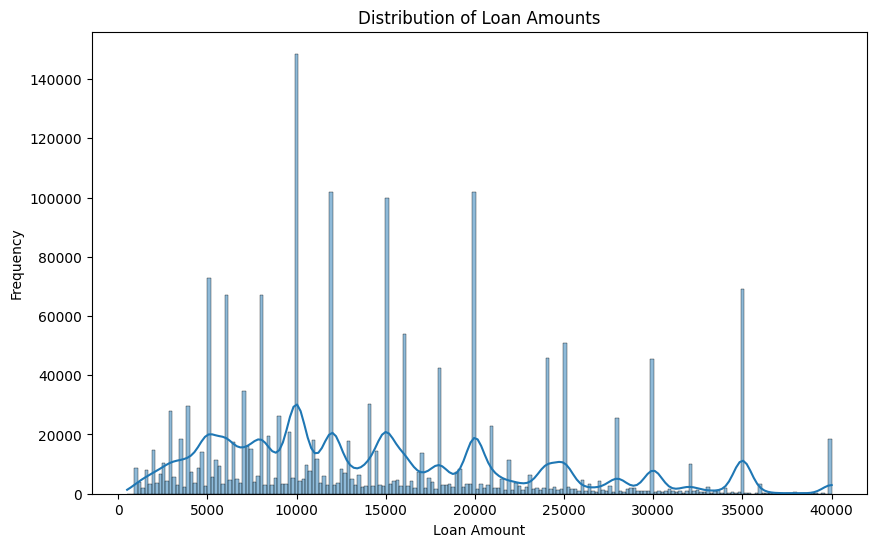

In [24]:
# Plot 1: Distribution of Loan Amounts
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['loan_amnt'], kde=True)
plt.title('Distribution of Loan Amounts')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

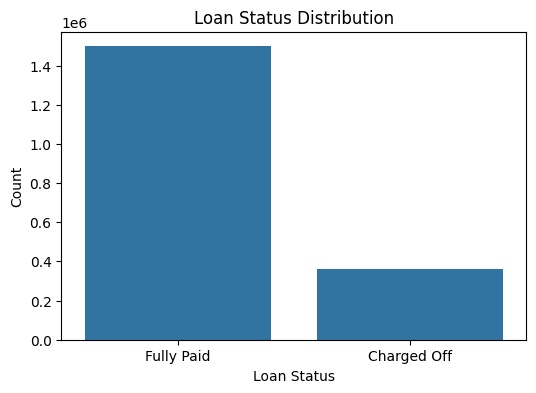

In [25]:
# Plot 2: Loan Status Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=df_cleaned)
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fully Paid', 'Charged Off'])
plt.show()

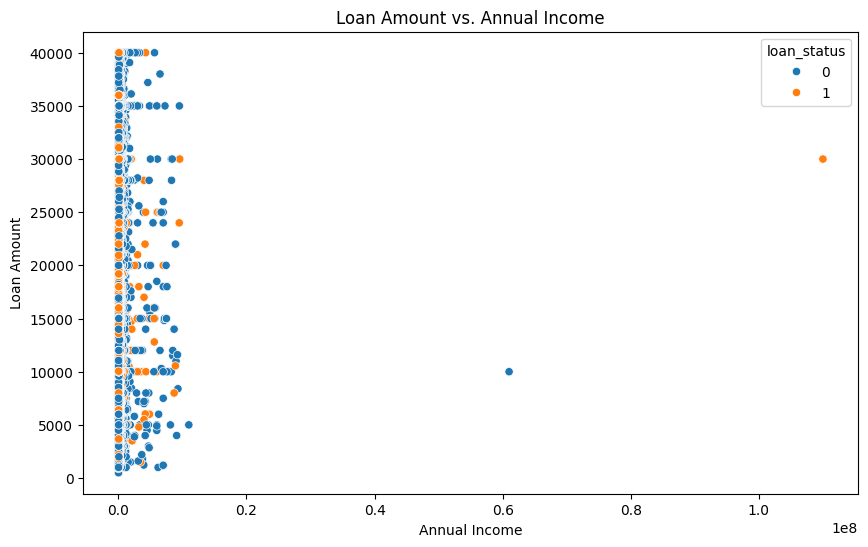

In [27]:
# Plot 3: Loan Amount vs. Annual Income
#This plot helps me to understand if there’s a pattern in loan amounts with respect to the income levels and how the loan status (Fully Paid vs. Charged Off) is distributed across different income brackets.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='annual_inc', y='loan_amnt', hue='loan_status', data=df_cleaned)
plt.title('Loan Amount vs. Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.show()

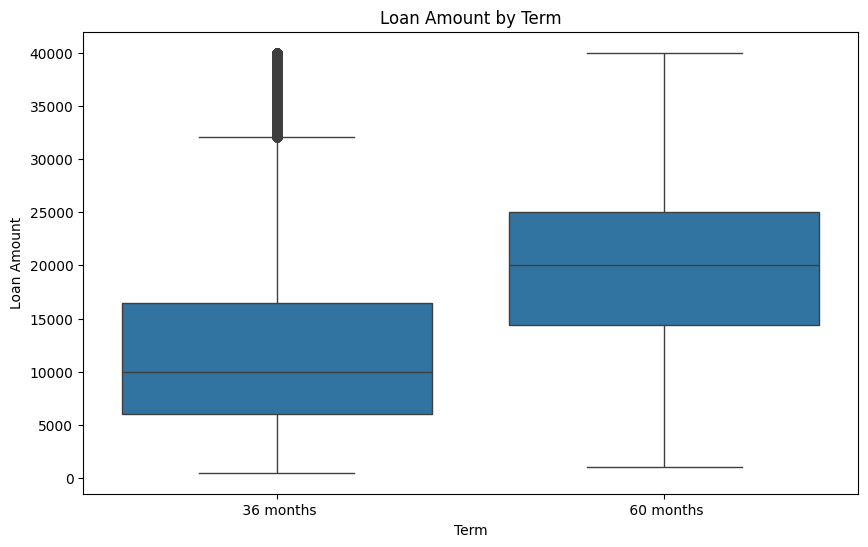

In [28]:
# Plot 4: Loan Amount by Term
plt.figure(figsize=(10, 6))
sns.boxplot(x='term', y='loan_amnt', data=df_cleaned)
plt.title('Loan Amount by Term')
plt.xlabel('Term')
plt.ylabel('Loan Amount')
plt.show()

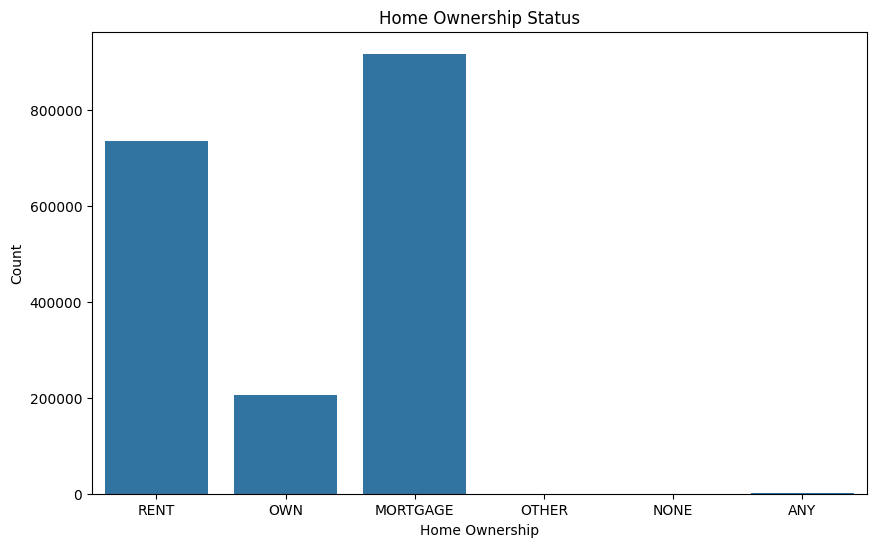

In [29]:
# Plot 5: Home Ownership Status
plt.figure(figsize=(10, 6))
sns.countplot(x='home_ownership', data=df_cleaned)
plt.title('Home Ownership Status')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.show()

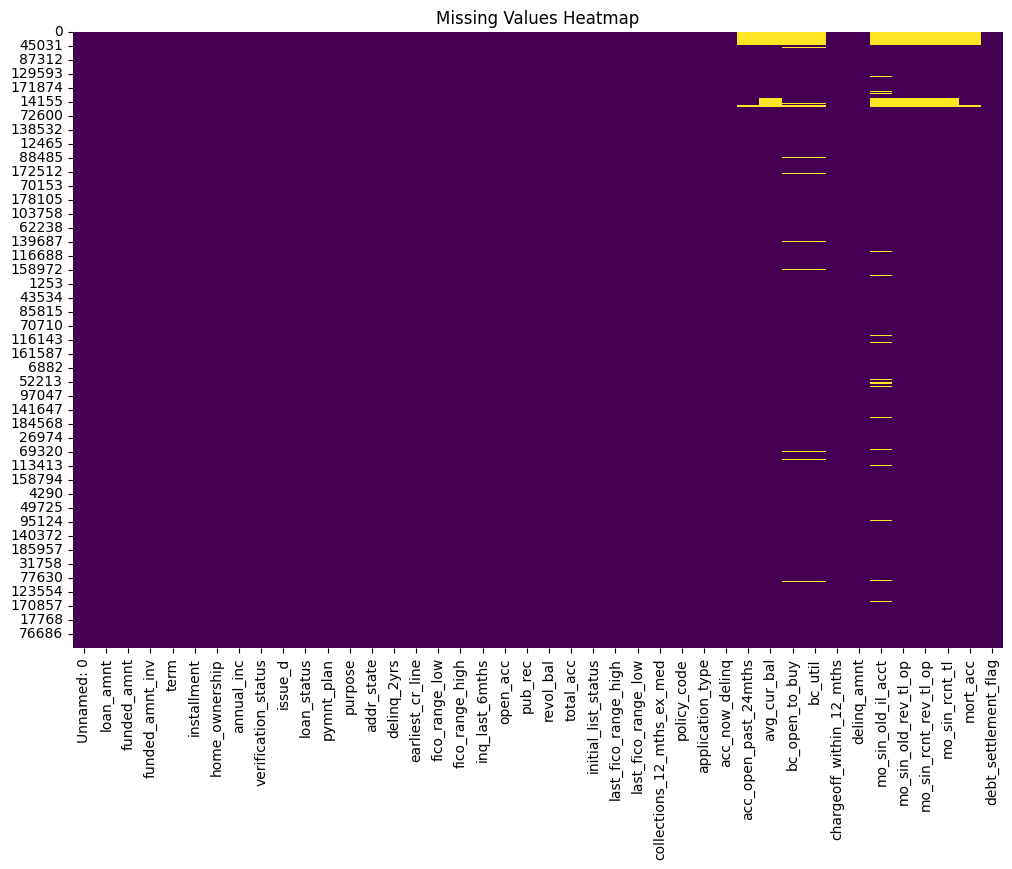

In [17]:
# Plot 6: Missing Values Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

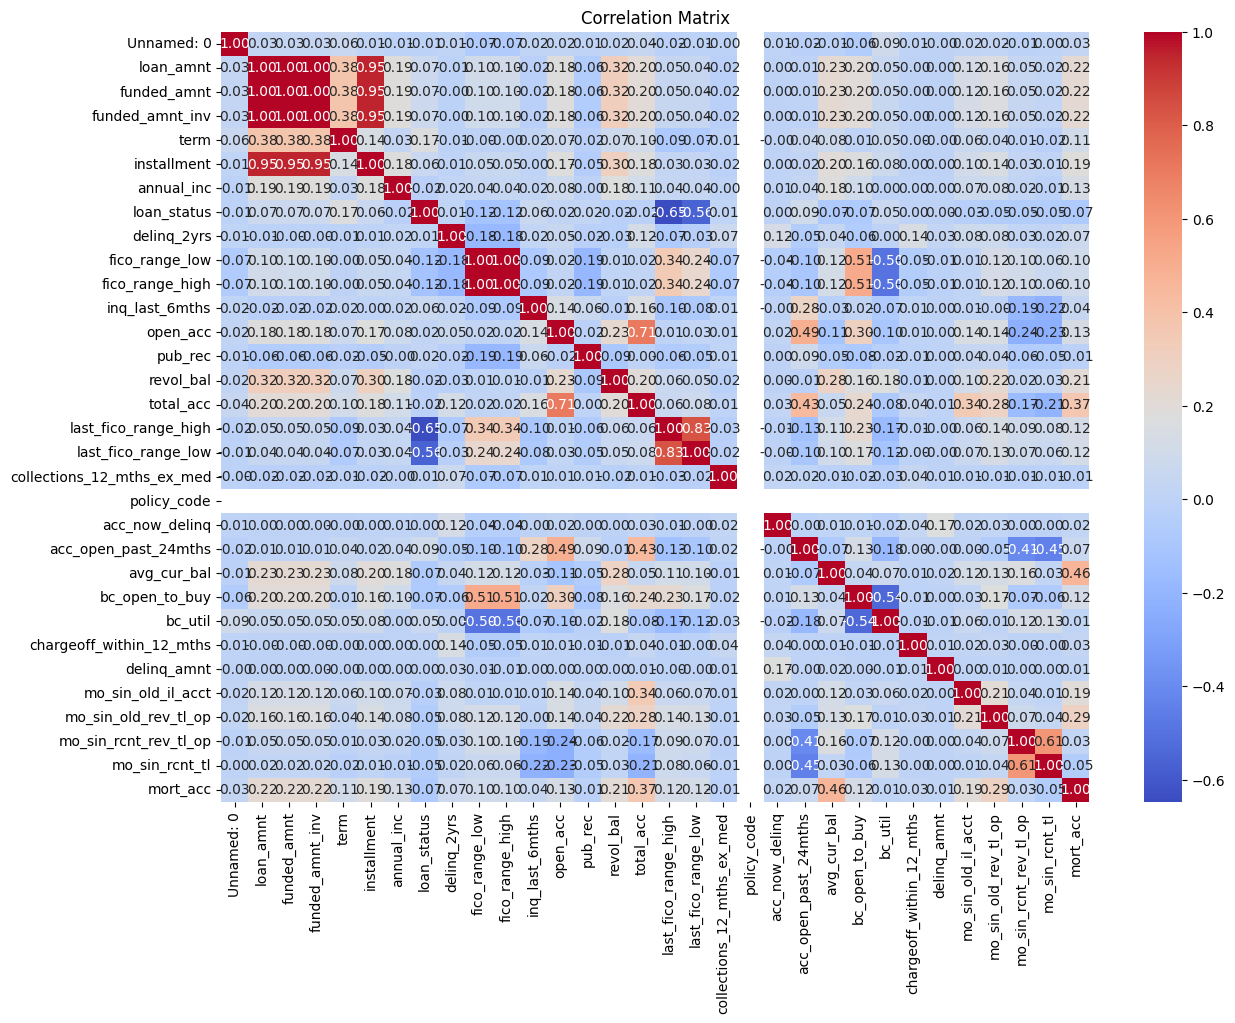

In [22]:
# Plot 7: Correlation Matrix only for numerical columns
numerical_df = df_cleaned.select_dtypes(include=[np.number])
plt.figure(figsize=(14, 10))
corr_matrix = numerical_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### **Build a machine learning model: model implementation**
#### Based on the data we have and the time and resources available, I found two valid approaches for our classification.

| Approach              | Pros                                       | Cons                             |
|-----------------------|--------------------------------------------|----------------------------------|
| **Logistic Regression** | Simple, interpretable, fast to train      | May not capture complex relationships |
| **Random Forest**     | Handles non-linear relationships, robust to overfitting | Less interpretable, longer training time |



##### First approach: LogisticRegression

In [38]:
# Selecting features and target variable
X = df_cleaned.drop('loan_status', axis=1)
y = df_cleaned['loan_status']

# One-hot encoding categorical variables
X = pd.get_dummies(X)

# Handling missing values by imputing with mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test_scaled)

In [39]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[428578  20453]
 [ 29308  79761]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95    449031
           1       0.80      0.73      0.76    109069

    accuracy                           0.91    558100
   macro avg       0.87      0.84      0.85    558100
weighted avg       0.91      0.91      0.91    558100


Accuracy Score:
0.9108385593979573


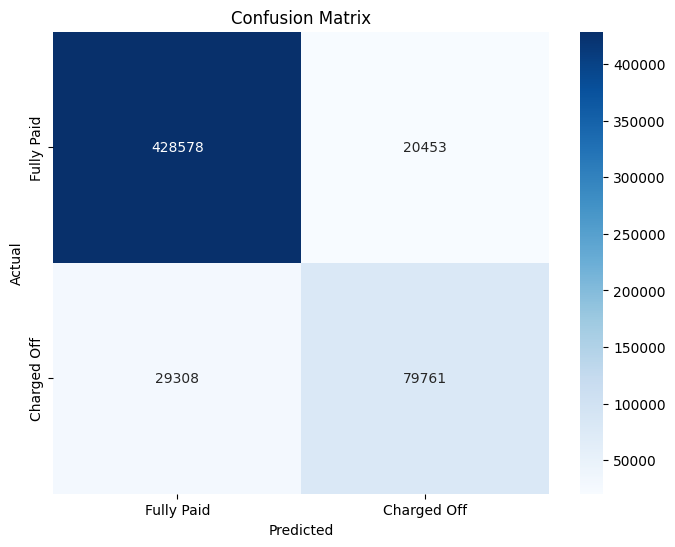

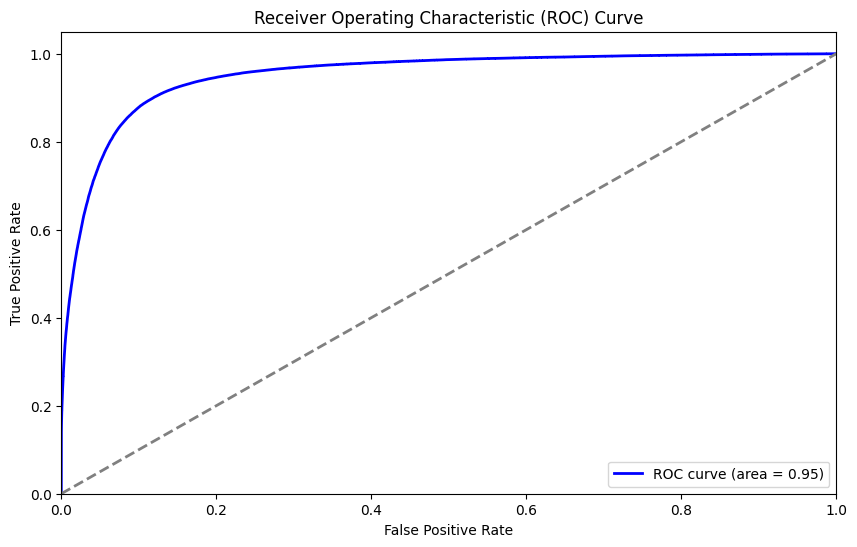

In [40]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fully Paid', 'Charged Off'], yticklabels=['Fully Paid', 'Charged Off'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plotting ROC Curve
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### Second approach

In [ ]:
# We need to handle missing values before building the model
# For simplicity, we will fill NaN values with the median for numerical columns and the mode for categorical columns

df_processed = df_cleaned.copy()

for column in df_processed.columns:
    if df_processed[column].dtype == 'object':
        df_processed[column].fillna(df_processed[column].mode()[0], inplace=True)
    else:
        df_processed[column].fillna(df_processed[column].median(), inplace=True)

# Verify there are no more missing values
print(df_processed.isna().sum().sum())

# Encode categorical variables
df_encoded = pd.get_dummies(df_processed, drop_first=True)

# Split the data into training and testing sets
X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Import and train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)


In [35]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[283864  15413]
 [ 17422  55368]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95    299277
           1       0.78      0.76      0.77     72790

    accuracy                           0.91    372067
   macro avg       0.86      0.85      0.86    372067
weighted avg       0.91      0.91      0.91    372067


Accuracy Score:
0.9117497654992246


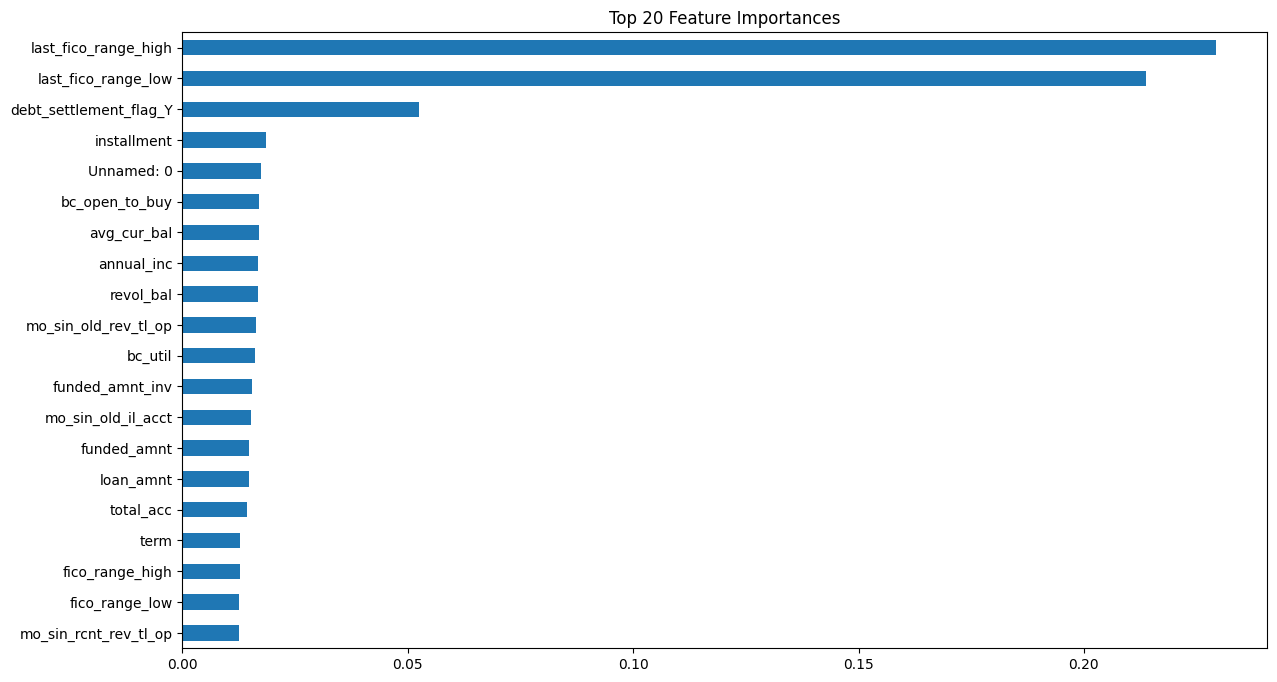

In [36]:
# 4) Explain (as in “explainability”) your model in terms of the classifier’s features.
# Feature Importance
plt.figure(figsize=(14, 8))
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).sort_values().plot(kind='barh')
plt.title('Top 20 Feature Importances')
plt.show()